In [ ]:

import gzip
from collections import defaultdict
import math
import operator
import scipy.optimize
from sklearn import svm
import numpy as np
import string
import random
import string
from sklearn import linear_model
import warnings
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import scipy
import pandas as pd
import numpy as np
class Utilites:
    def readGz(path):
        for l in gzip.open(path, 'rt'):
            yield eval(l)

    def punctuations():
        return set(string.punctuation)

    def readCSV(path):
        f = gzip.open(path, 'rt')
        f.readline()
        for l in f:
            u, b, r = l.strip().split(',')
            r = int(r)
            yield u, b, r

    def Cosine(x1, x2):
        numer = 0
        norm1 = 0
        norm2 = 0
        for a1, a2 in zip(x1, x2):
            numer += a1*a2
            norm1 += a1**2
            norm2 += a2**2
        if norm1*norm2:
            return numer / math.sqrt(norm1*norm2)
        return 0

    def featureTFIDF(dataset, rev, punctuation, words, df):
        tf = defaultdict(int)
        r = ''.join([c for c in rev['review_text'].lower()
                    if not c in punctuation])
        for w in r.split():
            # Note = rather than +=, different versions of tf could be used instead
            tf[w] = 1
        tfidf = dict(
            zip(words, [tf[w] * math.log2(len(dataset) / df[w]) for w in words]))
        maxTf = [(tf[w], w) for w in words]
        maxTf.sort(reverse=True)
        maxTfIdf = [(tfidf[w], w) for w in words]
        maxTfIdf.sort(reverse=True)
        return tfidf, maxTfIdf

    def frequencyCalc(data, size=1000, limit=5):
        wordCount = defaultdict(int)
        punctuation = set(string.punctuation)
        my_stopwords = nltk.corpus.stopwords.words('english')
        for d in data:
            r = ''.join([c for c in d['review_text'].lower()
                        if not c in punctuation])
            for w in r.split():
                if w not in my_stopwords and len(w) >= 2:
                    wordCount[w] += 1

        wordFrequency = [(wordCount[w], w) for w in wordCount]
        wordFrequency.sort()
        wordFrequency.reverse()
        wordFrequency = [(x[0], x[1]) for x in wordFrequency if x[0] >= limit]
        words = [x[1] for x in wordFrequency[:size]]
        return words, wordFrequency


In [ ]:
users_review_data = []
reviews_data = []
users_items_data = []
items_data = []
bundle_data = []

for d in Utilites.readGz("user_reviews.json.gz"):
    users_review_data.append(d)

#for d in Utilites.readGz("/work/steam_reviews.json.gz"):
    #reviews_data.append(d)

for d in Utilites.readGz("users_items.json.gz"):
    users_items_data.append(d)

for d in Utilites.readGz("steam_games.json.gz"):
    items_data.append(d)

for d in Utilites.readGz("bundle_data.json.gz"):
    bundle_data.append(d)

In [ ]:
users_items_train = []
users_items_validation = []
users_items_test = []
users_per_item_train = defaultdict(set)
items_per_user_train = defaultdict(set)
times_per_game_total = defaultdict()
times_per_game = defaultdict(list)


for d in users_items_data:
    games_played_by_user = d['items']
    random.shuffle(games_played_by_user)

    for i in range(len(games_played_by_user)):
        times_per_game[games_played_by_user[i]['item_id']].append(
            games_played_by_user[i]['playtime_forever'])
        if(games_played_by_user[i]['item_id'] in times_per_game_total):
            if(games_played_by_user[i]['playtime_forever'] != 0):
                times_per_game_total[games_played_by_user[i]['item_id']][0] += games_played_by_user[i]['playtime_forever']
                times_per_game_total[games_played_by_user[i]['item_id']][1] += 1
        else:
            times_per_game_total[games_played_by_user[i]['item_id']] = [games_played_by_user[i]['playtime_forever'],1]
        if(i < len(games_played_by_user) * 0.6):
            users_items_train.append((d['user_id'], games_played_by_user[i]))
            items_per_user_train[d['user_id']].add((games_played_by_user[i]['item_id'],games_played_by_user[i]['playtime_forever'],games_played_by_user[i]['playtime_2weeks']))
            users_per_item_train[games_played_by_user[i]['item_id']].add((d['user_id'],games_played_by_user[i]['playtime_forever'],games_played_by_user[i]['playtime_2weeks']))

        elif(i < len(games_played_by_user) * 0.8):
            users_items_validation.append((d['user_id'], games_played_by_user[i]))
        else:
            users_items_test.append((d['user_id'], games_played_by_user[i]))


In [187]:
def features(data):
    x =[]
    y = []
    for user,gameInfo in data:
        if(gameInfo['playtime_forever'] == 0): y.append(0)
        elif(gameInfo['playtime_forever'] <= 45): y.append(1)
        elif(gameInfo['playtime_forever'] <= 220): y.append(2)
        elif(gameInfo['playtime_forever'] <= 840): y.append(3)
        else: y.append(4)
        x.append((user,gameInfo['item_id']))
    return x, y

In [ ]:
users_items_data[0]

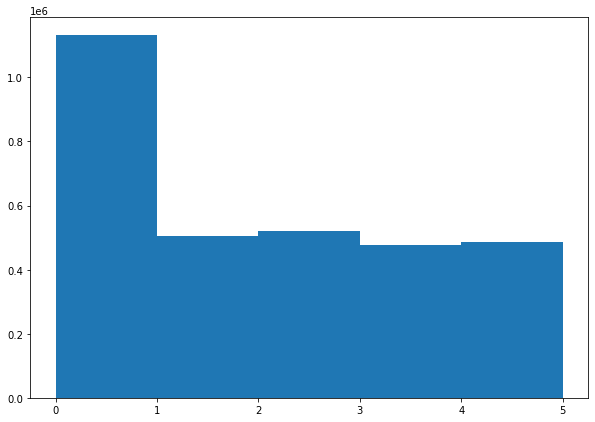

In [168]:

from matplotlib import pyplot as plt
import numpy as np
trainX, trainY = features(users_items_train)
# Creating dataset
a = np.array(trainY)
# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
threshold = []
for i in range(0,1000,60):
    threshold.append(i)
ax.hist(a, bins=[0,1,2,3,4,5])
 
# Show plot
plt.show()


In [ ]:
trainX, trainY = features(users_items_train)


In [ ]:
len(trainX)

In [ ]:
trainX[:5]

In [ ]:
trainY[:5]

In [ ]:
len(trainX)

In [ ]:
times_per_game['10']

In [ ]:
games = defaultdict()
for d in items_data:
    if(d.__contains__('id')):
        games[d['id']] = d
    else:
        print(d)
        if(d['url'].split('/')[-1] != ''):
            games[d['url'].split('/')[-1]] = d


2879.4327591917854

In [226]:

validationX, validationY = features(users_items_validation)
y_pred = []
i = 0
threshold = np.array([0, 45,220,840, 1460])

for user, item in validationX:
    avg_time = times_per_game_total[item][0] / times_per_game_total[item][1]
    diff = np.abs(threshold - avg_time)
    print(diff)
    y_pred.append(np.argmin(diff))
    # if(avg_time < 1): 
    #     y_pred.append(0)
    #     print(avg_time)
    # elif(0 < avg_time <= 45): y_pred.append(1)
    # elif(avg_time <= 220): y_pred.append(2)
    # elif(avg_time<= 840): y_pred.append(3)
    # else: y_pred.append(4)


In [ ]:
y_pred[0:5]

[2, 3, 3, 3, 2]

In [ ]:
len(y_pred)

1029873

In [ ]:
len(validationY)

1029873

In [ ]:
validationY[0:5]

[0, 3, 2, 4, 0]

In [ ]:
users_per_item_train['221910']


{('LordRascus', 1, 0),
 ('shadoworso', 162, 0),
 ('scootypuffsr', 133, 0),
 ('BaronFD', 20, 0),
 ('this_is_my_link', 90, 0),
 ('faffandtheworldfaffswithyou', 38, 0),
 ('ch33kyt1g3r', 263, 0),
 ('Feel_Good_Inc', 160, 0),
 ('00000000000000000001227', 131, 0),
 ('Suparcoffeeninja', 0, 0),
 ('mrsaucepons', 377, 0),
 ('Iceman_Raikkonen', 69, 0),
 ('MEDSBUMM', 0, 0),
 ('76561198045815259', 34, 0),
 ('Shilor', 93, 0),
 ('Unice', 59, 0),
 ('76561198065990570', 25, 0),
 ('mattsumus', 220, 0),
 ('BigSmokePhil', 185, 0),
 ('76561198081461581', 104, 0),
 ('staphstalkingme', 47, 0),
 ('1337putin', 178, 0),
 ('brauley', 231, 0),
 ('OzLocutus', 31, 0),
 ('Thugorran', 0, 0),
 ('76561197987627104', 222, 0),
 ('76561198049923824', 191, 0),
 ('Jay-san', 231, 0),
 ('apricotpieeeeee', 32, 0),
 ('76561198020054096', 87, 0),
 ('76561198023404136', 0, 0),
 ('mda7', 0, 0),
 ('thisisnick', 76, 0),
 ('76561198054540475', 95, 0),
 ('76561198046167823', 132, 0),
 ('76561198059652172', 86, 0),
 ('MyWeakness', 92, 0

In [ ]:
len(y_pred)


In [ ]:
len(trainX)

In [ ]:
len(trainY)

1002285

In [ ]:
correct = np.array(y_pred) == np.array(validationY)


In [ ]:
sum(correct) / len(correct)


0.2254879970637156